In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')

In [2]:
# Import and manipulate trend data
trend2 = pd.read_csv('trend2.csv')
trend2.columns = trend2.columns.map(str.strip)
trend2 = trend2.dropna(axis = 0, how = 'any')
trend2 = trend2.reset_index()
trend2 = trend2.drop('index', 1)

In [3]:
trend2.head()

,country,year,church2,cc,gini_net,rgdpl
0,Australia,1965,26.182790,Australia,29.16514,15.23929
1,Australia,1967,24.744380,Australia,29.50664,16.25018
2,Australia,1979,4.442971,Australia,25.75894,21.58357
3,Australia,1981,27.626460,Australia,28.10000,22.46979
4,Australia,1984,18.099700,Australia,28.80875,23.45019


In [4]:
# Lookup table for each unique country, for indexing
trend2.country = trend2.country.map(str.strip)
countries = trend2.country.unique()
numberOfCountries = len(countries)
countryLookup = dict(zip(countries, range(numberOfCountries)))

In [5]:
# Create local copies of variables.
country = trend2['countryCode'] = trend2.country.replace(countryLookup).values
religiosity = trend2.church2
trend2['logReligiosity'] = logReligiosity = np.log(religiosity).values
giniNet = trend2.gini_net.values

In [6]:
trend2.head()

,country,year,church2,cc,gini_net,rgdpl,countryCode,logReligiosity
0,Australia,1965,26.182790,Australia,29.16514,15.23929,0,3.265102
1,Australia,1967,24.744380,Australia,29.50664,16.25018,0,3.208598
2,Australia,1979,4.442971,Australia,25.75894,21.58357,0,1.491323
3,Australia,1981,27.626460,Australia,28.10000,22.46979,0,3.318774
4,Australia,1984,18.099700,Australia,28.80875,23.45019,0,2.895895


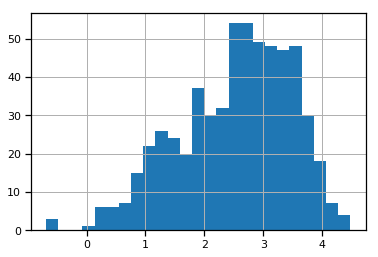

In [7]:
# Distribution of religiosity levels across countries (log scale):
trend2.church2.apply(lambda x: np.log(x)).hist(bins = 25);

In [8]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz

In [9]:
# Partial pooling model - Hierarchical model
# Estimates for countries with less year data will shrink towards the world average.
# Estimates for countries with more year data will be closer to the unpooled country estimates.
giniNet = trend2.gini_net.values
logReligiosity = trend2.logReligiosity.values

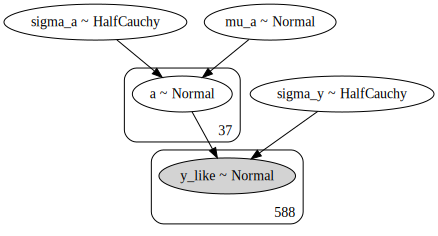

In [10]:
with Model() as partialPooling:

    # Priors
    mu_a = Normal('mu_a', mu=0., sd=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sd=sigma_a, shape=numberOfCountries)

    # Model error
    sigma_y = HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a[country]

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=logReligiosity)

model_to_graphviz(partialPooling)

In [11]:
with partialPooling:
    partialPoolingTrace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, a, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 660.73draws/s]


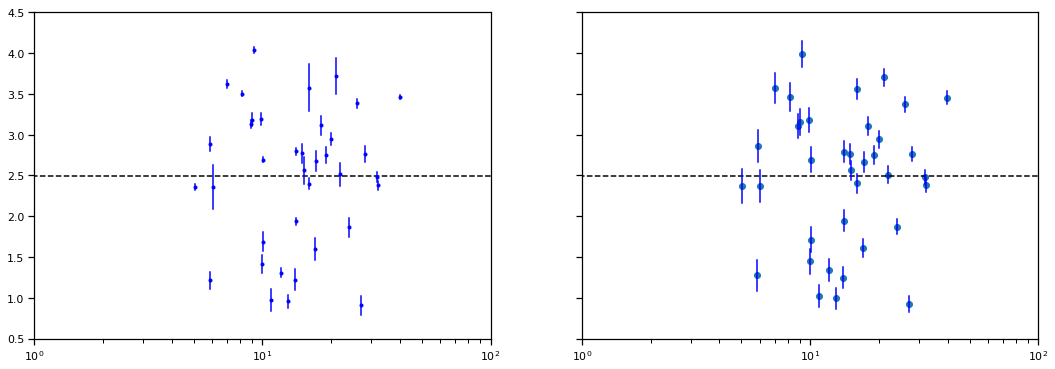

In [12]:
sampleTrace = partialPoolingTrace['a']

fig, axes = plt.subplots(1, 2, figsize=(18,6), sharex=True, sharey=True)
samples, numberOfCountries = sampleTrace.shape
jitter = np.random.normal(scale=0.1, size=numberOfCountries)

# Get count of the sampled years for each country
nCountry = trend2.groupby('country')['year'].count()

# Unpooled approach
unpooledMeans = trend2.groupby('country')['logReligiosity'].mean()
unpooledSd = trend2.groupby('country')['logReligiosity'].std()
unpooled = pd.DataFrame({'n':nCountry, 'm':unpooledMeans, 'sd':unpooledSd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sampleTrace.mean(), 0.9, 100, linestyles='--')

# Partially pooled approach
samples, numberOfCountries = sampleTrace.shape
means = sampleTrace.mean(axis=0)
sd = sampleTrace.std(axis=0)
axes[1].scatter(nCountry.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0.5, 4.5)
axes[1].hlines(sampleTrace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, nCountry.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')

Difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes can be noticed.

# Model with the Varying Intercepts 

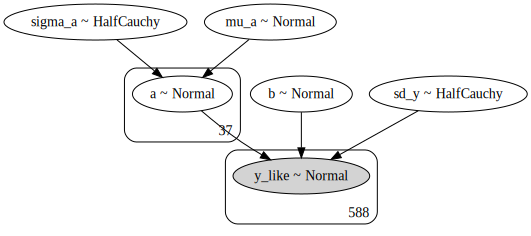

In [13]:
# Include varying intercepts for country and the year
with Model() as varyingIntercept:

    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sd=sigma_a, shape=numberOfCountries)
    
    # Common slope
    b = Normal('b', mu=0., sd=1e5)

    # Model error
    sd_y = HalfCauchy('sd_y', 5)

    # Expected value
    y_hat = a[country] + b * giniNet

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sd_y, observed=logReligiosity)

model_to_graphviz(varyingIntercept)

In [15]:
# Fit the model using MCMC
with varyingIntercept:
    varyingInterceptTrace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_y, b, a, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:16<00:00, 247.57draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
from pymc3 import forestplot, traceplot, plot_posterior

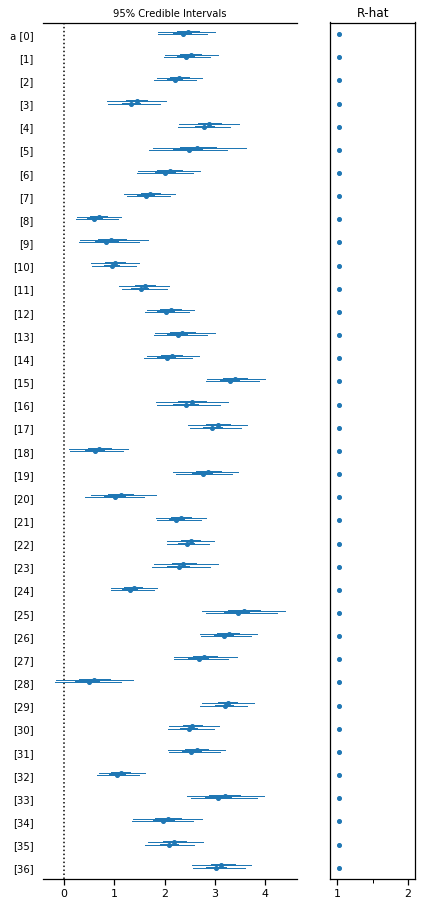

In [17]:
plt.figure(figsize=(6,14))
forestplot(varyingInterceptTrace, varnames=['a']);

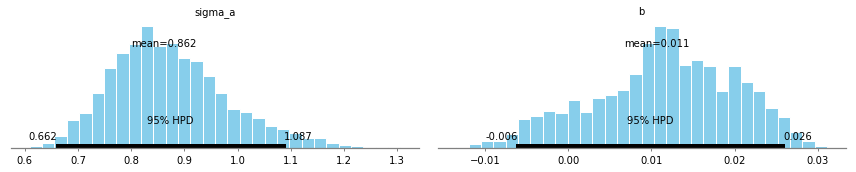

In [18]:
plot_posterior(varyingInterceptTrace, varnames=['sigma_a', 'b']);

In [19]:
from pymc3 import summary

In [20]:
summary(varyingInterceptTrace, varnames=['b'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b,0.010682,0.008573,0.000767,-0.00603,0.025805,37.621336,1.02949


The estimate for the giniNet coefficient is approximately 0.011

# Show estimates for some sample countries

In [21]:
sampleCountries = ('Australia', 'Chile', 'Turkey',
                    'United States', 'Ireland', 'Ukraine', 'Italy', 'Israel')

In [23]:
bp = varyingInterceptTrace[a].mean(axis=0)
mp = varyingInterceptTrace[b].mean()

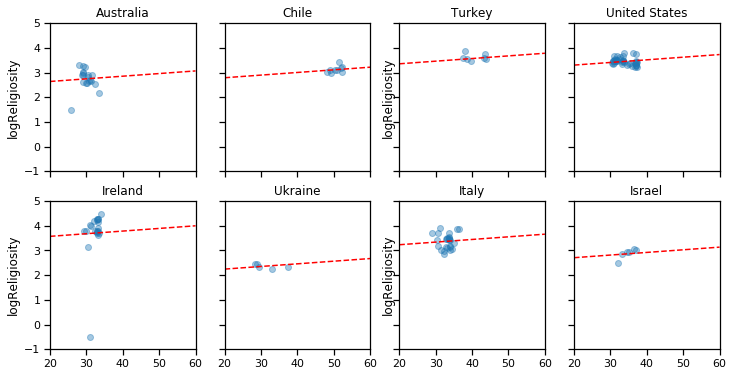

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sampleCountries):

    # Plot country data
    y = trend2.logReligiosity[trend2.country==c]
    x = trend2.gini_net[trend2.country==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    xvals = np.linspace(20, 60)
    # Partial pooling estimate
    axes[i].plot(xvals, mp*xvals+bp[countryLookup[c]], 'r--')
    axes[i].set_ylim(-1, 5)
    axes[i].set_xlim(20,60)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('logReligiosity')

It is noticable that the partial pooling model provides reasonable estimates, even for countries with small sample sizes of different years.

# New model with informative beta prior

Chosing highly informative prior beta value that is relatively far away from the posterior estimate from last model with little standard deviation and mu around 0.03 which is far from 0.01

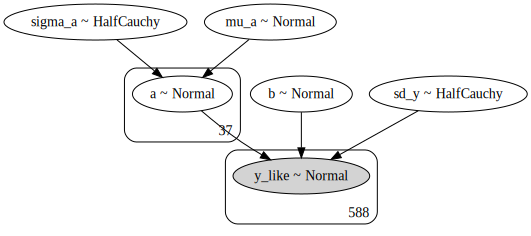

In [25]:
with Model() as varyingInterceptWithPriorBeta:

    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sd=sigma_a, shape=numberOfCountries)
    
    # Common slope
    b = Normal('b', mu=0.03, sd=0.01)

    # Model error
    sd_y = HalfCauchy('sd_y', 5)

    # Expected value
    y_hat = a[country] + b * giniNet

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sd_y, observed=logReligiosity)

model_to_graphviz(varyingInterceptWithPriorBeta)

In [27]:
with varyingInterceptWithPriorBeta:
    varyingInterceptTraceWithPriorBeta = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_y, b, a, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:18<00:00, 215.99draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


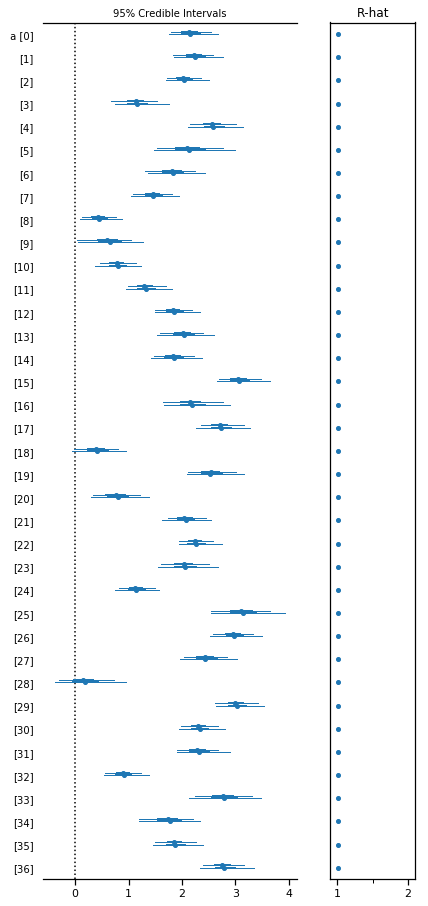

In [28]:
plt.figure(figsize=(6,14))
forestplot(varyingInterceptTraceWithPriorBeta, varnames=['a']);

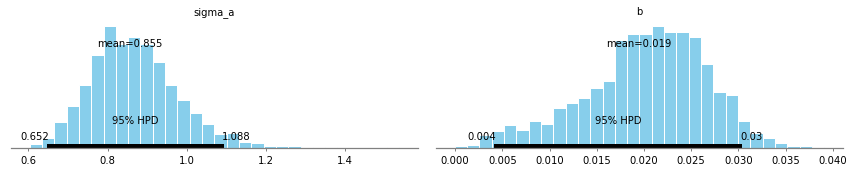

In [29]:
plot_posterior(varyingInterceptTraceWithPriorBeta, varnames=['sigma_a', 'b']);

In [30]:
summary(varyingInterceptTraceWithPriorBeta, varnames=['b'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b,0.019481,0.006582,0.000575,0.004306,0.030189,41.78965,1.00831


The estimate for the giniNet coefficient is changed from 0.011 to 0.019 with informative beta prior.

### Comparision of Informative and Uninformative Prior

When the prior was uninformative, the posterior was very much determined by the data. On the other hand, when the prior is informative as in second model, the posterior is a mixture of the prior and the data. The more informative the prior, the more data is needed to "change" your beliefs (prior), so to speak because the posterior is very much driven by the prior information. But if there is a lot of data, the data will dominate the posterior distribution (they will overwhelm the prior)